# Malware Detection in Network Traffic Data

## Imports and spark setup

In [32]:
import os
from tqdm import tqdm
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Malware") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "6") \
    .config("spark.executor.instances", "2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.cores", "3") \
    .config("spark.default.parallelism", "6") \
    .config("spark.sql.shuffle.partitions", "6") \
    .getOrCreate()

sc = spark.sparkContext

In [33]:
sc.getConf().getAll()

[('spark.sql.warehouse.dir',
  'file:/C:/Users/Vincenzo/Projects/DDAM_Project_23-24/code/spark-warehouse'),
 ('spark.default.parallelism', '6'),
 ('spark.driver.port', '58485'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1702570501058'),
 ('spark.driver.cores', '3'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.u

## Dataset concatenation / data assesment / schema corrections [preprocessing]

In [34]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Define your custom schema
custom_schema = StructType([
    StructField("ts", DoubleType(), True),
    StructField("uid", StringType(), True),
    StructField("id.orig_h", StringType(), True),
    StructField("id.orig_p", StringType(), True),
    StructField("id.resp_h", StringType(), True),
    StructField("id.resp_p", StringType(), True),
    StructField("proto", StringType(), True),
    StructField("service", StringType(), True),
    StructField("duration", DoubleType(), True),
    StructField("orig_bytes", DoubleType(), True),
    StructField("resp_bytes", DoubleType(), True),
    StructField("conn_state", StringType(), True),
    StructField("local_orig", StringType(), True),
    StructField("local_resp", StringType(), True),
    StructField("missed_bytes", DoubleType(), True),
    StructField("history", StringType(), True),
    StructField("orig_pkts", DoubleType(), True),
    StructField("orig_ip_bytes", DoubleType(), True),
    StructField("resp_pkts", DoubleType(), True),
    StructField("resp_ip_bytes", DoubleType(), True),
    StructField("tunnel_parents", StringType(), True),
    StructField("label", StringType(), True),
    StructField("detailed-label", StringType(), True),
])

# List of file paths
file_paths = [
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv",
    r"C:\Users\Vincenzo\Projects\DDAM_data\malware\CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv",
]

# Initialize an empty DataFrame with the custom schema
df = spark.createDataFrame(spark.sparkContext.emptyRDD(), custom_schema)

# Use tqdm for progress bar
for file_path in tqdm(file_paths, desc="Reading files", unit="file"):
    df_temp = spark.read.option("escape", "\"").option("delimiter", "|").csv(file_path, header=True, schema=custom_schema)
    df = df.union(df_temp)

df = df.drop("uid")

df.show(5)
df.printSchema()


Reading files: 100%|██████████| 11/11 [00:00<00:00, 78.75file/s]


+-------------------+---------------+---------+---------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------+--------------------+
|                 ts|      id.orig_h|id.orig_p|      id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|    label|      detailed-label|
+-------------------+---------------+---------+---------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------+--------------------+
|1.525879831015811E9|192.168.100.103|    51524| 65.127.233.163|       23|  tcp|      -|2.999051|       0.0|       0.0|        S0|         -|         -|         0.0|      S|      3.0|        180.0|   

In [35]:
df = df.sample(False, 0.01, seed=0)

In [36]:
rows, cols = df.count(), len(df.columns)
print(f'Dimension of the whole Dataframe is: {(rows,cols)}')

Dimension of the whole Dataframe is: (249984, 22)


In [37]:
#replacing dots with underscores in column names to avoid errors

df = df.toDF(*(c.replace('.', '_') for c in df.columns))
df = df.toDF(*(c.replace('-', '_') for c in df.columns))

In [38]:
# #looking for the coluns that have the '-' value to later work on them

# from pyspark.sql.functions import col

# columns_with_dash = [col_name for col_name in df.columns if df.filter(col(col_name) == "-").count() > 0]
# print("Columns with '-' values:", columns_with_dash)

In [39]:
from pyspark.sql.functions import col, when

columns_with_dash = ['service', 'local_orig', 'local_resp', 'history', 'tunnel_parents', 'detailed_label']

def replace_dash_with_nan(df, columns):

    result_df = df
    for column in columns:
        result_df = result_df.withColumn(column, when(col(column) == '-', None).otherwise(col(column)))

    return result_df

df = replace_dash_with_nan(df, columns_with_dash)

In [40]:
from pyspark.sql.functions import isnan, when, count, col, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---------+---------+---------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+-----+--------------+
| ts|id_orig_h|id_orig_p|id_resp_h|id_resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed_label|
+---+---------+---------+---------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+-----+--------------+
|  0|        0|        0|        0|        0|    0| 249804|  152600|    152600|    152600|         0|    249984|    249984|           0|    264|        0|            0|        0|            0|        249984|    0|        179640|
+---+---------+---------+---------+---------+-----+-------+--------+----------+-----

In [41]:
df = df.dropna(subset=["history"])

In [42]:
ip_inferred = ["local_orig", "local_resp"]
missing_values = ['service', 'tunnel_parents']
binary = ["duration", "orig_bytes", "resp_bytes", "detailed_label"]

df_binary = df.drop(*ip_inferred + missing_values + binary)
df_multi= df.drop(*(ip_inferred + missing_values))

In [43]:
dfs = {'df': df, 'df_binary': df_binary, 'df_multi': df_multi}

for name, current_df in dfs.items():
    rows, cols = current_df.count(), len(current_df.columns)
    print(f'Dimensions of the DataFrame {name} are: {(rows, cols)}')

Dimensions of the DataFrame df are: (249720, 22)
Dimensions of the DataFrame df_binary are: (249720, 14)
Dimensions of the DataFrame df_multi are: (249720, 18)


In [44]:
from pyspark.sql.functions import isnan, when, count, col, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---------+---------+---------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+-----+--------------+
| ts|id_orig_h|id_orig_p|id_resp_h|id_resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed_label|
+---+---------+---------+---------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+-----+--------------+
|  0|        0|        0|        0|        0|    0| 249540|  152384|    152384|    152384|         0|    249720|    249720|           0|      0|        0|            0|        0|            0|        249720|    0|        179376|
+---+---------+---------+---------+---------+-----+-------+--------+----------+-----

In [45]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window_spec = Window.partitionBy('id_orig_h', 'id_resp_h')

# Extract features from IP addresses
df_binary = df_binary.withColumn('id_orig_h_features', F.split('id_orig_h', r'\.')[0]) \
                .withColumn('id_resp_h_features', F.split('id_resp_h', r'\.')[0]) \
                .withColumn('is_internal_orig', F.when(F.split('id_orig_h', r'\.')[0] == '192', 1).otherwise(0)) \
                .withColumn('is_internal_resp', F.when(F.split('id_resp_h', r'\.')[0] == '192', 1).otherwise(0)) \
                .withColumn('common_orig_dest_pairs', F.count('id_orig_h').over(window_spec)) \
                .withColumn('hour_of_day', F.hour(F.from_unixtime('ts'))) \
                .withColumn('day_of_week', F.dayofweek(F.from_unixtime('ts')))
                
                
# Select relevant columns for prediction
selected_columns_feature_extraction = ['id_orig_h_features', 'id_resp_h_features', 'is_internal_orig', 'is_internal_resp', 'common_orig_dest_pairs', 'hour_of_day', 'day_of_week']
df_selected_IPfeatures = df_binary.select(selected_columns_feature_extraction).drop('id_orig_h', 'id_resp_h')

# # Convert columns to integer
df_binary = df_binary.withColumn("id_orig_h_features", col("id_orig_h_features").cast("integer"))
df_binary = df_binary.withColumn("id_resp_h_features", col("id_resp_h_features").cast("integer"))

#print schema
df_selected_IPfeatures.printSchema()

root
 |-- id_orig_h_features: string (nullable = true)
 |-- id_resp_h_features: string (nullable = true)
 |-- is_internal_orig: integer (nullable = false)
 |-- is_internal_resp: integer (nullable = false)
 |-- common_orig_dest_pairs: long (nullable = false)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [46]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Columns for StringIndexing
string_indexing_cols = ['id_orig_p', 'id_resp_p', 'proto', 'conn_state', 'label', 'history']

# Create a dictionary to store label mappings
label_mappings = {}

indexers = []
for col_name in string_indexing_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+'_index', handleInvalid='keep')
    model = indexer.fit(df_binary)
    indexers.append(model)
    
    # Get label mapping for the current column
    label_mapping = dict(enumerate(model.labels))
    label_mappings[col_name] = label_mapping

# Create a pipeline with StringIndexer stages
pipeline = Pipeline(stages=indexers)
df_binary = pipeline.fit(df_binary).transform(df_binary)

# Select relevant columns for prediction
selected_columns_string_index = ['id_orig_p', 'id_resp_p', 'proto', 'conn_state', 'label', 'history']
selected_columns_string_index += [f'{col_name}_index' for col_name in string_indexing_cols]

df_selected_string_index = df_binary.select(selected_columns_string_index).drop(*string_indexing_cols)

# Print schema
df_selected_string_index.printSchema()

# Print label mappings
for col_name, mapping in label_mappings.items():
    print(f"Label mapping for {col_name}: {mapping}")


root
 |-- id_orig_p_index: double (nullable = false)
 |-- id_resp_p_index: double (nullable = false)
 |-- proto_index: double (nullable = false)
 |-- conn_state_index: double (nullable = false)
 |-- label_index: double (nullable = false)
 |-- history_index: double (nullable = false)

Label mapping for id_orig_p: {0: '43763', 1: '123', 2: '65279', 3: '29930', 4: '43763.0', 5: '59734', 6: '62336', 7: '55588', 8: '36836', 9: '39538', 10: '39716', 11: '42538', 12: '43168', 13: '45514', 14: '52008', 15: '52804', 16: '54582', 17: '55180', 18: '58028', 19: '36462', 20: '36728', 21: '36784', 22: '38224', 23: '43094', 24: '46708', 25: '46936', 26: '47214', 27: '47558', 28: '48242', 29: '49198', 30: '50094', 31: '53576', 32: '37610', 33: '40424', 34: '40610', 35: '40720', 36: '40788', 37: '41062', 38: '41082', 39: '41776', 40: '41912', 41: '42128', 42: '42600', 43: '42652', 44: '43754', 45: '44120', 46: '44488', 47: '44744', 48: '47004', 49: '47218', 50: '48106', 51: '48582', 52: '49194', 53: '4

In [47]:
ip = df_selected_IPfeatures.schema.names
string_index = df_selected_string_index.schema.names
num_cols = ["missed_bytes" , "orig_pkts" , "orig_ip_bytes" , "resp_pkts" , "resp_ip_bytes"]

selected_features = ip + string_index + num_cols

df_binary = df_binary.select(selected_features)
df_binary.printSchema()

root
 |-- id_orig_h_features: integer (nullable = true)
 |-- id_resp_h_features: integer (nullable = true)
 |-- is_internal_orig: integer (nullable = false)
 |-- is_internal_resp: integer (nullable = false)
 |-- common_orig_dest_pairs: long (nullable = false)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- id_orig_p_index: double (nullable = false)
 |-- id_resp_p_index: double (nullable = false)
 |-- proto_index: double (nullable = false)
 |-- conn_state_index: double (nullable = false)
 |-- label_index: double (nullable = false)
 |-- history_index: double (nullable = false)
 |-- missed_bytes: double (nullable = true)
 |-- orig_pkts: double (nullable = true)
 |-- orig_ip_bytes: double (nullable = true)
 |-- resp_pkts: double (nullable = true)
 |-- resp_ip_bytes: double (nullable = true)



In [48]:
from pyspark.sql.functions import isnan, when, count, col, isnull
missing = df_binary.select([count(when(isnull(c), c)).alias(c) for c in df_binary.columns]).show()

+------------------+------------------+----------------+----------------+----------------------+-----------+-----------+---------------+---------------+-----------+----------------+-----------+-------------+------------+---------+-------------+---------+-------------+
|id_orig_h_features|id_resp_h_features|is_internal_orig|is_internal_resp|common_orig_dest_pairs|hour_of_day|day_of_week|id_orig_p_index|id_resp_p_index|proto_index|conn_state_index|label_index|history_index|missed_bytes|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|
+------------------+------------------+----------------+----------------+----------------------+-----------+-----------+---------------+---------------+-----------+----------------+-----------+-------------+------------+---------+-------------+---------+-------------+
|                 0|                 0|               0|               0|                     0|          0|          0|              0|              0|          0|               0|          0|

In [49]:
rows, cols = df_binary.count(), len(df_binary.columns)
print(f'Dimension of the whole Dataframe is: {(rows,cols)}')

Dimension of the whole Dataframe is: (249720, 18)


In [50]:
df_binary.printSchema()

root
 |-- id_orig_h_features: integer (nullable = true)
 |-- id_resp_h_features: integer (nullable = true)
 |-- is_internal_orig: integer (nullable = false)
 |-- is_internal_resp: integer (nullable = false)
 |-- common_orig_dest_pairs: long (nullable = false)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- id_orig_p_index: double (nullable = false)
 |-- id_resp_p_index: double (nullable = false)
 |-- proto_index: double (nullable = false)
 |-- conn_state_index: double (nullable = false)
 |-- label_index: double (nullable = false)
 |-- history_index: double (nullable = false)
 |-- missed_bytes: double (nullable = true)
 |-- orig_pkts: double (nullable = true)
 |-- orig_ip_bytes: double (nullable = true)
 |-- resp_pkts: double (nullable = true)
 |-- resp_ip_bytes: double (nullable = true)



## Data understanding

### dimension and content analysis

In [51]:
rows, cols = df_binary.count(), len(df_binary.columns)
print(f'Dimension of the whole Dataframe is: {(rows,cols)}')

Dimension of the whole Dataframe is: (249720, 18)


In [52]:
num_cols = [item[0] for item in df_binary.dtypes if item[1] != 'string']
print('Le colonne numeriche sono {}'.format(len(num_cols)))
print(num_cols)

Le colonne numeriche sono 18
['id_orig_h_features', 'id_resp_h_features', 'is_internal_orig', 'is_internal_resp', 'common_orig_dest_pairs', 'hour_of_day', 'day_of_week', 'id_orig_p_index', 'id_resp_p_index', 'proto_index', 'conn_state_index', 'label_index', 'history_index', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']


In [53]:
non_num_cols = [item[0] for item in df_binary.dtypes if item[1] == 'string']
print('Le colonne non numeriche sono {}'.format(len(non_num_cols)))
print(non_num_cols)

Le colonne non numeriche sono 0
[]


### interesting plots

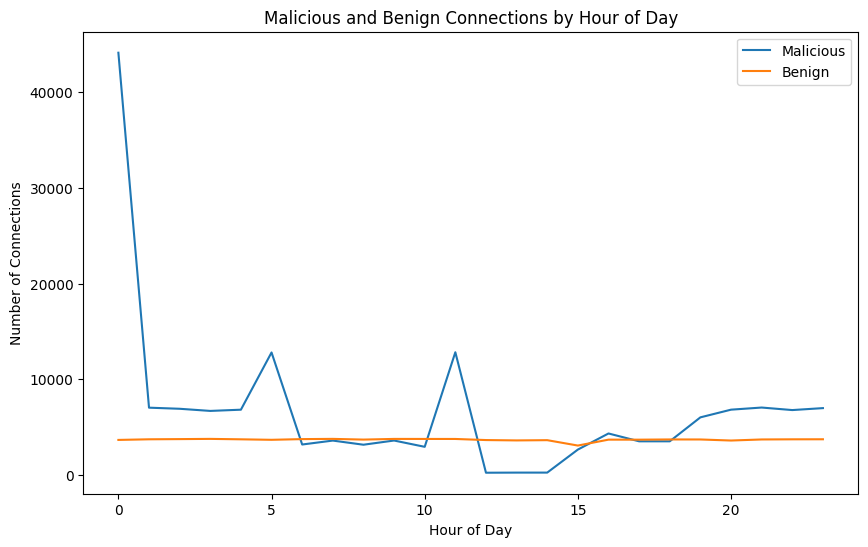

In [54]:
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have a SparkSession named 'spark'
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming 'label_index' is your column containing the label indices
# Create a new column 'label_category' to aggregate non-benign labels under 'malicious'
label_mapping = {0: 'Benign', 1: 'Malicious', 2: 'Malicious DDoS', 3: 'Malicious PartOfAHorizontalPortScan', 4: 'Malicious C&C', 5: 'Malicious Attack'}
df_plot = df_binary.withColumn('label_category', when(df_binary.label_index == 0.0, 'benign').otherwise('malicious'))

# Create a temporary view
df_plot.createOrReplaceTempView("connection_data")

# Use Spark SQL to filter data for malicious and benign connections
malicious_df = spark.sql("SELECT * FROM connection_data WHERE label_category = 'malicious'")
benign_df = spark.sql("SELECT * FROM connection_data WHERE label_category = 'benign'")

# Group data by hour_of_day and count the number of connections
malicious_counts = malicious_df.groupBy("hour_of_day").count().toPandas()
benign_counts = benign_df.groupBy("hour_of_day").count().toPandas()

# Merge the two DataFrames on hour_of_day
merged_df = pd.merge(malicious_counts, benign_counts, on="hour_of_day", suffixes=('_malicious', '_benign'))

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='hour_of_day', y='count_malicious', label='Malicious')
sns.lineplot(data=merged_df, x='hour_of_day', y='count_benign', label='Benign')
plt.title('Malicious and Benign Connections by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Connections')
plt.legend()
plt.show()


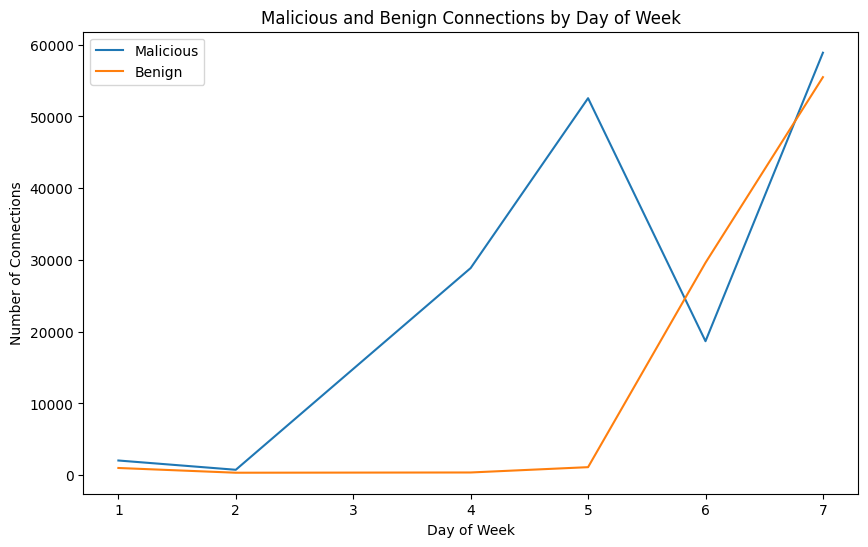

In [55]:
from pyspark.sql.functions import when
from pyspark.sql import SparkSession

# Assuming you have a SparkSession named 'spark'
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming 'label_index' is your column containing the label indices
# Create a new column 'label_category' to aggregate non-benign labels under 'malicious'
label_mapping = {0: 'Benign', 1: 'Malicious', 2: 'Malicious DDoS', 3: 'Malicious PartOfAHorizontalPortScan', 4: 'Malicious C&C', 5: 'Malicious Attack'}
df_plot = df_binary.withColumn('label_category', when(df_binary.label_index == 0.0, 'benign').otherwise('malicious'))

# Create a temporary view
df_plot.createOrReplaceTempView("connection_data")

# Use Spark SQL to filter data for malicious and benign connections
malicious_df = spark.sql("SELECT * FROM connection_data WHERE label_category = 'malicious'")
benign_df = spark.sql("SELECT * FROM connection_data WHERE label_category = 'benign'")

# Group data by day_of_week and count the number of connections
malicious_counts = malicious_df.groupBy("day_of_week").count().toPandas()
benign_counts = benign_df.groupBy("day_of_week").count().toPandas()

# Merge the two DataFrames on day_of_week
merged_df = pd.merge(malicious_counts, benign_counts, on="day_of_week", suffixes=('_malicious', '_benign'))

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='day_of_week', y='count_malicious', label='Malicious')
sns.lineplot(data=merged_df, x='day_of_week', y='count_benign', label='Benign')
plt.title('Malicious and Benign Connections by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Connections')
plt.legend()
plt.show()


### Check for distinct values and raw statistics

In [58]:
from pyspark.sql.functions import col, countDistinct


def count_distinct_values(df):
    result = {}
    columns = df.columns

    # Use tqdm to create a progress bar
    for column in tqdm(columns, desc="Counting Distinct Values", unit="column"):
        distinct_count = df.select(column).agg(countDistinct(column)).collect()[0][0]
        result[column] = distinct_count

    return result

distinct_counts = count_distinct_values(df_binary)

for column, count in distinct_counts.items():
    print(f"Column '{column}' has {count} distinct values.")

Counting Distinct Values: 100%|██████████| 18/18 [01:21<00:00,  4.51s/column]

Column 'id_orig_h_features' has 6 distinct values.
Column 'id_resp_h_features' has 255 distinct values.
Column 'is_internal_orig' has 2 distinct values.
Column 'is_internal_resp' has 2 distinct values.
Column 'common_orig_dest_pairs' has 24 distinct values.
Column 'hour_of_day' has 24 distinct values.
Column 'day_of_week' has 7 distinct values.
Column 'id_orig_p_index' has 59015 distinct values.
Column 'id_resp_p_index' has 4323 distinct values.
Column 'proto_index' has 2 distinct values.
Column 'conn_state_index' has 12 distinct values.
Column 'label_index' has 6 distinct values.
Column 'history_index' has 47 distinct values.
Column 'missed_bytes' has 1 distinct values.
Column 'orig_pkts' has 73 distinct values.
Column 'orig_ip_bytes' has 197 distinct values.
Column 'resp_pkts' has 37 distinct values.
Column 'resp_ip_bytes' has 145 distinct values.


In [59]:
# Use the describe function to get statistical summary

summary = df_binary.describe().toPandas()
summary

,summary,id_orig_h_features,id_resp_h_features,is_internal_orig,is_internal_resp,common_orig_dest_pairs,hour_of_day,day_of_week,id_orig_p_index,id_resp_p_index,proto_index,conn_state_index,label_index,history_index,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,count,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720,249720
1,mean,191.99633990068878,136.95046852474772,0.9998878744193497,0.004180682364247958,5874.783397405094,9.442427518821079,5.929629184686849,15356.621135671952,38.30058865929841,0.017199263174755727,0.32273346147685406,1.1498478295691175,0.39118612846387957,0.0,266.38121095627105,7773.984426557745,0.012265737626141278,1.3169629985583855
2,stddev,0.3829980357936283,55.60601515923393,0.010588364248605873,0.06452302636092862,12464.116835786685,7.896081584627169,1.2303751589404253,14513.05441111351,326.10991882956966,0.13001352318462409,0.6397310153842493,1.0511997052283075,0.8832540276864983,0.0,132128.71690572283,3831732.695351429,0.4585390389389591,54.015583853245865
3,min,105,1,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,192,255,1,1,35738,23,7,59014.0,4322.0,1.0,11.0,5.0,46.0,0.0,6.6027354E7,1.914793266E9,42.0,4687.0


## Classification